In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorboard
import matplotlib
import numpy as np
import pandas as pd

tensorflow==2.4.1
tensorboard==2.4.1
matplotlib==3.1.1
numpy==1.19.5
pandas==0.25.1


### Transfomer encoder

#### Positional encoding

In [6]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 10000, 100)


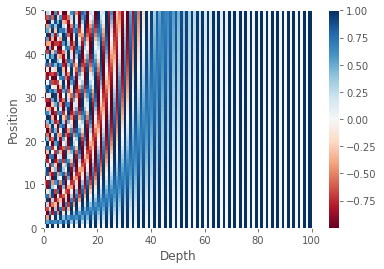

In [7]:
pos = 10000
d_model = 100
pos_encoding = positional_encoding(pos, d_model)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0][:50,:], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, d_model))
plt.ylabel('Position')
plt.colorbar()
plt.show()

#### Masks

padding_mask: [[[[0. 0. 1. 1. 1.]]]


 [[[0. 0. 0. 1. 1.]]]


 [[[0. 0. 0. 0. 0.]]]]


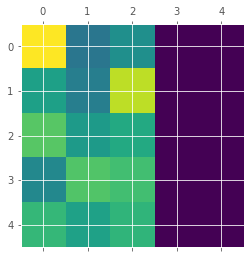

In [8]:
def create_padding_mask(seq, padding_token=0):
  """
  Creates a mask with ones where padding_token is found and zeros elsewhere.
  This mask is added to the attention logits in order to prevent the 
  model to focus in padding tokens.

  Args:
    seq: tensor with shape (batch_size, maxlen)
    padding_token: token for padding, Default: 0.
  Returns:
    mask of shape (batch_size, 1, 1, maxlen)
  """
  seq = tf.cast(tf.math.equal(seq, padding_token), tf.float32)
  # add extra dimensions to add the padding
  # to the attention logits and match dimensions.
  mask = seq[:, tf.newaxis, tf.newaxis, :]
  return mask # (batch_size, 1, 1, maxlen)

tokens = tf.constant([[743, 623, 0, 0, 0], 
                 [132, 243, 453, 0, 0], 
                 [365, 400, 290, 265, 509]])
att_logits = tf.random.uniform((3,1,5,5)) # Simulate att logits (batch_size, num_heads, maxlen, maxlen)
padding_mask = create_padding_mask(tokens)
print(f"padding_mask: {padding_mask}")
masked_att_logits = att_logits + (padding_mask * -1e9)
att_weights =  tf.nn.softmax(masked_att_logits, axis=-1)
plt.matshow(att_weights[1,0,:,:].numpy())

look_ahead_mask: [[0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 1.]
 [0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0.]]
combined_masks:[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]]]


 [[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 1. 1.]]]


 [[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 0. 1. 1.]
   [0. 0. 0. 0. 1.]
   [0. 0. 0. 0. 0.]]]]


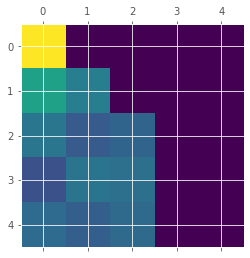

In [9]:
def create_look_ahead_mask(maxlen, match_dims=False):
  """
  Creates mask to causal attention. 
  This mask will prevent the model to focus on future tokens.

  Args:
    maxlen: maxlen of the sequence
  Returns:
    Tensor of shape (maxlen, maxlen) with its upper filled with 
    ones and zeros elsewhere  
  """
  mask = 1 - tf.linalg.band_part(tf.ones((maxlen, maxlen)), -1, 0)
  if match_dims:
    mask = mask[tf.newaxis, tf.newaxis, :, :]
  return mask

padding_mask = create_padding_mask(tokens)
look_ahead_mask = create_look_ahead_mask(tokens.shape[1])
combined_masks = tf.maximum(padding_mask, look_ahead_mask)
print(f"look_ahead_mask: {look_ahead_mask}")
print(f"combined_masks:{combined_masks}")
masked_att_logits = att_logits + (combined_masks * -1e9)
att_weights =  tf.nn.softmax(masked_att_logits, axis=-1)

plt.matshow(att_weights[1,0,:,:].numpy()) # Visualize attention weights in first head for secod input 

#### MultiHeadAttention

In [10]:
from tensorflow.keras.layers import Dense, LayerNormalization, Dropout

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        if d_model % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {d_model} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = d_model // num_heads

        self.query_dense = Dense(d_model)
        self.key_dense = Dense(d_model)
        self.value_dense = Dense(d_model)

        self.combine_heads = Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
      """
      Arguments:
        query: Query shape == (batch_size, num_heads, seq_len, projection_dim)
        key: Key shape == (batch_size, num_heads, seq_len, projection_dim)
        value: Value shape == (batch_size, num_heads, seq_len, projection_dim)

        Returns:
          output:            (batch_size, num_heads, seq_len, projection_dim) 
          attention_weights: (batch_size, num_heads, seq_len, seq_len)
      """
      dk = tf.cast(tf.shape(K)[-1], tf.float32)
      # (batch_size, num_heads, seq_len, seq_len)
      att_logits = tf.matmul(Q, K, transpose_b=True)
      scaled_att_logits = att_logits / tf.sqrt(dk) 
      if mask is not None:
        scaled_att_logits += (mask * -1e9)
      
      attention_weights = tf.nn.softmax(scaled_att_logits, axis=-1)
      # (batch_size, num_heads, seq_len, projection_dim)
      ooutput = attention_weights @ V
      return ooutput, attention_weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, Q, K, V, mask=None):
        """ 
          output, # (batch_size, seq_len, d_model) 
          weights # (batch_size, num_heads, seq_len, seq_len)
        """
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(Q)[0]
        query = self.query_dense(Q)  # (batch_size, seq_len, d_model)
        key = self.key_dense(K)  # (batch_size, seq_len, d_model)
        value = self.value_dense(V)  # (batch_size, seq_len, d_model)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.scaled_dot_product_attention(
            query, key, value, mask)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.d_model)
        )  # (batch_size, seq_len, d_model)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, num_heads, seq_len, seq_len)
        return output, weights 

(2, 1, 1, 5)


(TensorShape([2, 5, 100]), TensorShape([2, 5, 5, 5]))

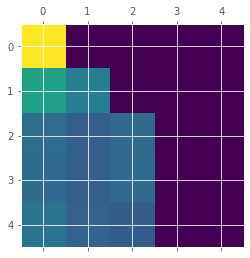

In [12]:
mha = MultiHeadAttention(d_model=100, num_heads=5)

tokens = tf.constant([[1, 2, 0, 0, 0], 
                      [3, 4, 5, 0, 0]])
x = tf.random.uniform((tokens.shape[0], tokens.shape[1], 100))  # (batch_size, maxlen, d_model)

padding_mask = create_padding_mask(tokens)
look_ahead_mask = create_look_ahead_mask(tokens.shape[1])
combined_mask = tf.maximum(padding_mask, look_ahead_mask)

print(padding_mask.shape)
out, att_weights = mha(x,x,x, mask=combined_mask)
plt.matshow(att_weights[1,0,:,:]) # Visualize causal self-attention in the first head for the second sample 
out.shape, att_weights.shape

#### Transformer Encoder Layer

In [14]:
class TransformerEncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, rate=0.2):
        super(TransformerEncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = tf.keras.Sequential([
                      Dense(ff_dim, activation="relu"), 
                      Dense(d_model),
            ]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training, mask=None):
        """
        output # (batch_size, seq_len, d_model) 
        weights # (batch_size, num_heads, seq_len, seq_len)
        """
        attn_output, weights = self.mha(inputs, inputs, inputs, mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        output = self.layernorm2(out1 + ffn_output)
        return output, weights

In [15]:
transformer = TransformerEncoderLayer(100,5,64)
inputs = tf.random.uniform((1, 50, 100))  # (batch_size, encoder_sequence, d_model)
out, weights = transformer(inputs)
out.shape, weights.shape

(TensorShape([1, 50, 100]), TensorShape([1, 5, 50, 50]))

In [16]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, token_embedding):
    """ 
    Layer for converting tokens ids into embeddings with positional information encoded 
    and create padding and look ahead masks (optional) 
    
    Args:
      token_embedding(tf.keras.layers.Embedding): Embedding layer
    Returns:
      Embeddings with   
    """
    super(PositionalEmbedding, self).__init__()
    self.vocab_size = token_embedding.input_dim
    self.d_model = token_embedding.output_dim 
    self.maxlen = token_embedding.input_length
    self.token_emb = token_embedding
    self.pos_encoding = positional_encoding(self.vocab_size, self.d_model)

  def call(self, input_tokens, training, causal_attention=False):
    """ 
    Computes embeddings for input tokens ids and apply them positional encoding
    Args:
      x (tensor): tensor with shape (batch_size, maxlen)
      causal_attention(bool): If True, padding mask is combined with look ahead mask. 
                              Otherwise only padding mask is created. 

    Returns:
      x: Positional encoded embeddings 
      mask: Padding mask for Multi Head Attention (with lookahead, optionally)
    """
    maxlen = tf.shape(input_tokens)[-1]
    mask = create_padding_mask(input_tokens)
    if causal_attention:
      look_ahead_mask = create_look_ahead_mask(maxlen)
      mask = tf.maximum(mask, look_ahead_mask)

    x = self.token_emb(input_tokens, training=training)  # (batch_size, maxlen, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :maxlen, :]
    return x, mask

In [17]:
class TransformerEncoder(tf.keras.models.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, embedding_layer, 
               causal_attention=False, dropout_rate=0.2):
    super(TransformerEncoder, self).__init__()
    self.d_model = d_model
    self.num_layers = num_layers
    self.embedding_layer = embedding_layer
    self.encoder_layers = [TransformerEncoderLayer(d_model, num_heads, dff, rate=dropout_rate) 
                           for _ in range(num_layers)]
    assert d_model == self.embedding_layer.output_dim, f"d_model and embedding output dim must be equal, {d_model} != {self.embedding_layer.output_dim}"
    self.positional_embedding = PositionalEmbedding(self.embedding_layer)
    self.causal_attention = causal_attention
    self.dropout = Dropout(dropout_rate)
    
  def call(self, input_tokens, training):
    """
    Args:
      input_tokens: tensor with shape (batch_size, maxlen) of tokens
    Returns:
      x: (batch_size, input_seq_len, d_model)
      layers_att_weights: dictionary with layer names as keys and 
                          attention weights of shape (batch_size, num_heads, maxlen, maxlen) 
                          for each layer as values 
    """
    embeddings, mask = self.positional_embedding(input_tokens, training=training, 
                                                 causal_attention=self.causal_attention)
    
    x = self.dropout(embeddings, training=training)
    
    layers_att_weights = {}

    for i in range(self.num_layers):
      x, weights = self.encoder_layers[i](x, training, mask)
      layers_att_weights[f"encoder_layer_{i+1}"] = weights
    return x, layers_att_weights